# Using the DeepMIMO Dataset with Sionna

In this example, you will learn how to use the ray-tracing based DeepMIMO dataset.

[DeepMIMO](https://deepmimo.net/) is a generic dataset that enables a wide range of machine/deep learning applications for MIMO systems. It takes as input a set of parameters (such as antenna array configurations and time-domain/OFDM parameters) and generates MIMO channel realizations, corresponding locations, angles of arrival/departure, etc., based on these parameters and on a ray-tracing scenario selected [from those available in DeepMIMO](https://deepmimo.net/scenarios/).

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Configuration of DeepMIMO](#Configuration-of-DeepMIMO)
* [Using DeepMIMO with Sionna](#Using-DeepMIMO-with-Sionna)
* [Link-level Simulations using Sionna and DeepMIMO](#Link-level-Simulations-using-Sionna-and-DeepMIMO)
* [DeepMIMO License and Citation](#DeepMIMO-License-and-Citation)

## GPU Configuration and Imports

In [ ]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.phy.config.seed = 42 # Set seed for reproducible random number generation

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load the required Sionna components
from sionna.phy import Block
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, \
                            LMMSEEqualizer, RZFPrecoder, RemoveNulledSubcarriers
from sionna.phy.channel import subcarrier_frequencies, ApplyOFDMChannel, \
                               GenerateOFDMChannel, CIRDataset
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import BinarySource, Mapper, Demapper
from sionna.phy.utils import ebnodb2no, sim_ber


## Configuration of DeepMIMO

DeepMIMO provides multiple [scenarios](https://deepmimo.net/scenarios/) that one can select from. Here, we use the `O1_60` scenario, which is an instance of O1 with the carrier frequency set to 60 GHz.

To use DeepMIMO with Sionna, the DeepMIMO dataset first needs to be generated. The generated DeepMIMO dataset contains channels for different locations of the users and basestations. The layout of the O1 scenario is shown in the figure below.

![img](https://deepmimo.net/examples/sionna_adapter_example.png)

In this example, we generate a dataset that consists of channels for the links from the basestation 6 to the users located on the rows 400 to 450. Each of these rows consists of 181 user locations, resulting in $51 \times 181 = 9231$ basestation-user channels.

The antenna arrays in the DeepMIMO dataset are defined as number of horizontal & vertical elements. In the following example, a single-user MISO downlink is considered. The basestation is equipped with a uniform linear array of 16 elements, which is oriented towards the positive x-axis by default. The users are each equipped with a single antenna. These parameters can be configured using the code below (for more information about the DeepMIMO parameters, please check [the DeepMIMO documentation](https://deepmimo.net/documentation).

In [ ]:
# Import DeepMIMO (install package if import fails)
try:
    import deepmimo as dm
except ImportError as e:
    import os
    os.system("pip install --pre deepmimo")
    import deepmimo as dm

In [ ]:
# Download the dataset
dm.download('O1_60')

# Load a BS-RX grid combination
load_params = {'max_paths': 10, 'tx_sets': [6], 'rx_sets': [0]}
dataset = dm.load('O1_60', **load_params)

# Select a subset of users in the dataset (and trim matrices)
sel_usr_idxs = dataset.get_row_idxs(range(400, 451))
dataset_t = dataset.subset(sel_usr_idxs)

Downloading: 100%|██████████| 2.30G/2.30G [00:45<00:00, 54.6MB/s]


✓ Downloaded to /content/deepmimo_scenarios/o1_60_downloaded.zip


Extracting: 100%|██████████| 4161/4161 [02:37<00:00, 26.34file/s] 


✓ Unzipped and moved to /content/deepmimo_scenarios
✓ Scenario 'o1_60' ready to use!
Loading TXRX PAIR: TXset 6 (tx_idx 0) & RXset 0 (rx_idxs 497931)


In [ ]:
# Channel generation
params = dm.ChannelParameters() # Load the default parameters

# Configuration of the antenna arrays
params.bs_antenna.shape = [16, 1] # BS antenna shape [horizontal, vertical]
params.ue_antenna.shape = [1, 1]  # UE antenna shape [horizontal, vertical]

# Configure time domain channels. Sionna will generate in frequency domain
params.freq_domain = False

# Generates a DeepMIMO dataset
dataset_t.compute_channels(params)
dataset_t.channels.shape # (num_rx, num_rx_ant, num_tx_ant, num_time)

Generating channels: 100%|██████████| 9231/9231 [00:00<00:00, 29525.95it/s]


(9231, 1, 16, 10)

### Visualization of the dataset

To provide a better understanding of the user and basestation locations, we next visualize the locations of the users, highlighting the first active row of users (row 400), and basestation 6.

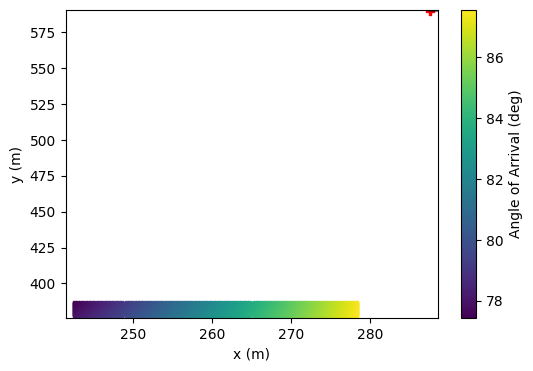

In [ ]:
 # Plot the azimuth of the AoA
dataset_t.aoa_az.plot(cbar_title='Angle of Arrival (deg)')

## Using DeepMIMO with Sionna

The DeepMIMO Python package provides [a Sionna-compliant channel impulse response generator](https://nvlabs.github.io/sionna/phy/tutorials/CIR_Dataset.html#Generators) that adapts the structure of the DeepMIMO dataset to be consistent with Sionna.

An adapter is instantiated for a given DeepMIMO dataset. The adapter only requires the dataset to adapt and it will generate samples for all users and basestations in that dataset.

In this example, `SionnaAdapter(dataset)` will return the channels from the basestation 6 and the 9231 available user locations.

**Note:** The adapter assumes basestations are transmitters and users are receivers. Uplink channels can be obtained using (transpose) reciprocity.

In [ ]:
from deepmimo.integrations import SionnaAdapter

deepmimo_sionna_adapter = SionnaAdapter(dataset_t)

## Link-level Simulations using Sionna and DeepMIMO

In the following cell, we define a Sionna model implementing the end-to-end link.

**Note:** The Sionna CIRDataset object shuffles the DeepMIMO channels provided by the adapter. Therefore, channel samples are passed through the model in a random order.

In [ ]:
class LinkModel(Block):
    def __init__(self,
                 DeepMIMO_Sionna_adapter,
                 carrier_frequency,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing = 60e3,
                 batch_size = 64
                ):
        super().__init__()

        self._batch_size = batch_size
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices

        # CIRDataset to parse the dataset
        self._CIR = CIRDataset(DeepMIMO_Sionna_adapter,
                               self._batch_size,
                               DeepMIMO_Sionna_adapter.num_rx,
                               DeepMIMO_Sionna_adapter.num_rx_ant,
                               DeepMIMO_Sionna_adapter.num_tx,
                               DeepMIMO_Sionna_adapter.num_tx_ant,
                               DeepMIMO_Sionna_adapter.num_paths,
                               DeepMIMO_Sionna_adapter.num_time_steps)

        # System parameters
        self._carrier_frequency = carrier_frequency
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 76
        self._num_ofdm_symbols = 14
        self._num_streams_per_tx = DeepMIMO_Sionna_adapter.num_rx
        self._dc_null = False
        self._num_guard_carriers = [0, 0]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 4
        self._coderate = 0.5

        # Setup the OFDM resource grid and stream management
        self._sm = StreamManagement(np.ones([DeepMIMO_Sionna_adapter.num_rx, 1], int), self._num_streams_per_tx)
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=DeepMIMO_Sionna_adapter.num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Components forming the link

        # Codeword length
        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        # Number of information bits per codeword
        self._k = int(self._n * self._coderate)

        # OFDM channel
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        self._ofdm_channel = GenerateOFDMChannel(self._CIR, self._rg, normalize_channel=True)
        self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        # Transmitter
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        self._zf_precoder = RZFPrecoder(self._rg, self._sm, return_effective_channel=True)

        # Receiver
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="lin_time_avg")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    def call(self, batch_size, ebno_db):

        # Transmitter
        b = self._binary_source([self._batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        # Generate the OFDM channel
        h_freq = self._ofdm_channel()
        # Precoding
        x_rg, g = self._zf_precoder(x_rg, h_freq)

        # Apply OFDM channel
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        y = self._channel_freq(x_rg, h_freq, no)

        # Receiver
        h_hat, err_var = self._ls_est (y, no)
        x_hat, no_eff = self._lmmse_equ(y, h_hat, err_var, no)
        llr = self._demapper(x_hat, no_eff)
        b_hat = self._decoder(llr)

        return b, b_hat

We next evaluate the setup with different $E_b/N_0$ values to obtain BLER curves.

In [ ]:
sim_params = {"ebno_db": np.linspace(-7, -5.25, 10),
              "cyclic_prefix_length" : 0,
              "pilot_ofdm_symbol_indices" : [2, 11]}

batch_size = 64
model = LinkModel(DeepMIMO_Sionna_adapter=deepmimo_sionna_adapter,
                  carrier_frequency=dataset_t.rt_params.frequency,
                  cyclic_prefix_length=sim_params["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=sim_params["pilot_ofdm_symbol_indices"])

ber, bler = sim_ber(model,
                    sim_params["ebno_db"],
                    batch_size=batch_size,
                    max_mc_iter=100,
                    num_target_block_errors=100,
                    graph_mode="graph")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -7.0 | 1.2781e-01 | 1.0000e+00 |       29840 |      233472 |          128 |         128 |         7.4 |reached target block errors
   -6.806 | 9.7352e-02 | 1.0000e+00 |       22729 |      233472 |          128 |         128 |         1.0 |reached target block errors
   -6.611 | 6.6376e-02 | 9.4531e-01 |       15497 |      233472 |          121 |         128 |         1.0 |reached target block errors
   -6.417 | 3.0492e-02 | 7.9688e-01 |        7119 |      233472 |          102 |         128 |         1.0 |reached target block errors
   -6.222 | 1.1498e-02 | 4.7656e-01 |        5369 |      466944 |          122 |         256 |         2.1 |reached target block errors
   -6.028 | 1.4813e-03 | 1.3281e-01 |        2075 |     1400832 |

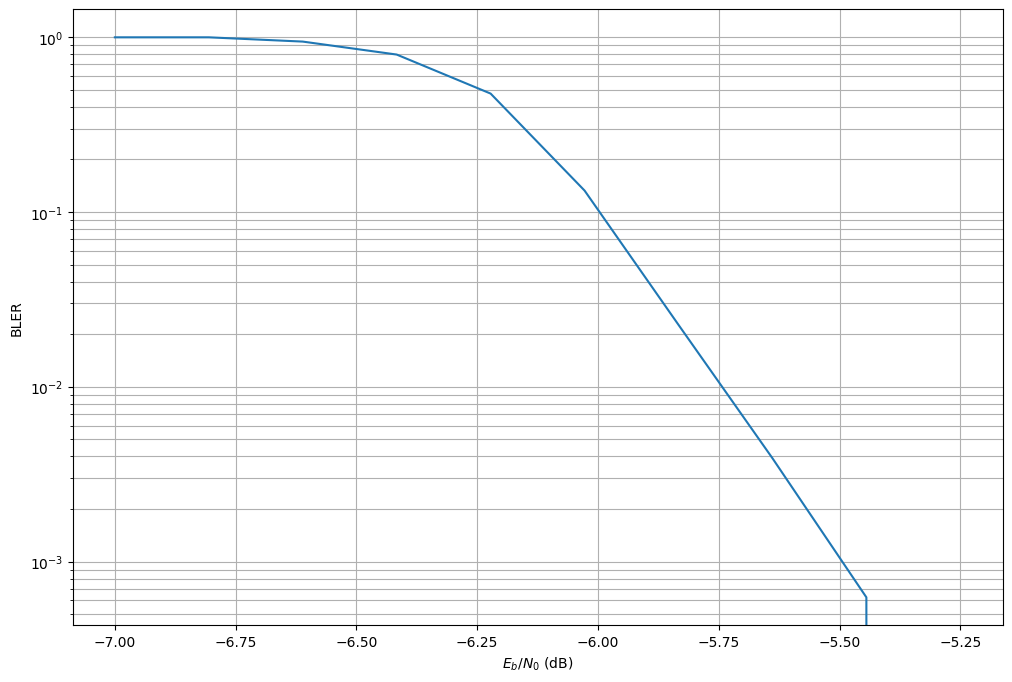

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.semilogy(sim_params["ebno_db"], bler)

## DeepMIMO License and Citation

A. Alkhateeb, “[DeepMIMO: A Generic Deep Learning Dataset for Millimeter Wave and Massive MIMO Applications](https://arxiv.org/pdf/1902.06435.pdf),” in Proc. of Information Theory and Applications Workshop (ITA), San Diego, CA, Feb. 2019.

To use the DeepMIMO dataset, please check the license information [here](https://deepmimo.net/license/).